## Problem Set #6
### MACS 30100, Dr. Evans
#### Xiang Zhang

#### (a)

In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
biden = pd.read_csv('https://raw.githubusercontent.com/UC-MACSS/persp-model_W18/master/ProblemSets/PS6/biden.csv')
biden.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [3]:
varlist = ["female", "age", "educ", "dem", "rep"]
X = biden[varlist].values
y = biden["biden"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

In [4]:
biden_tree = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 3)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

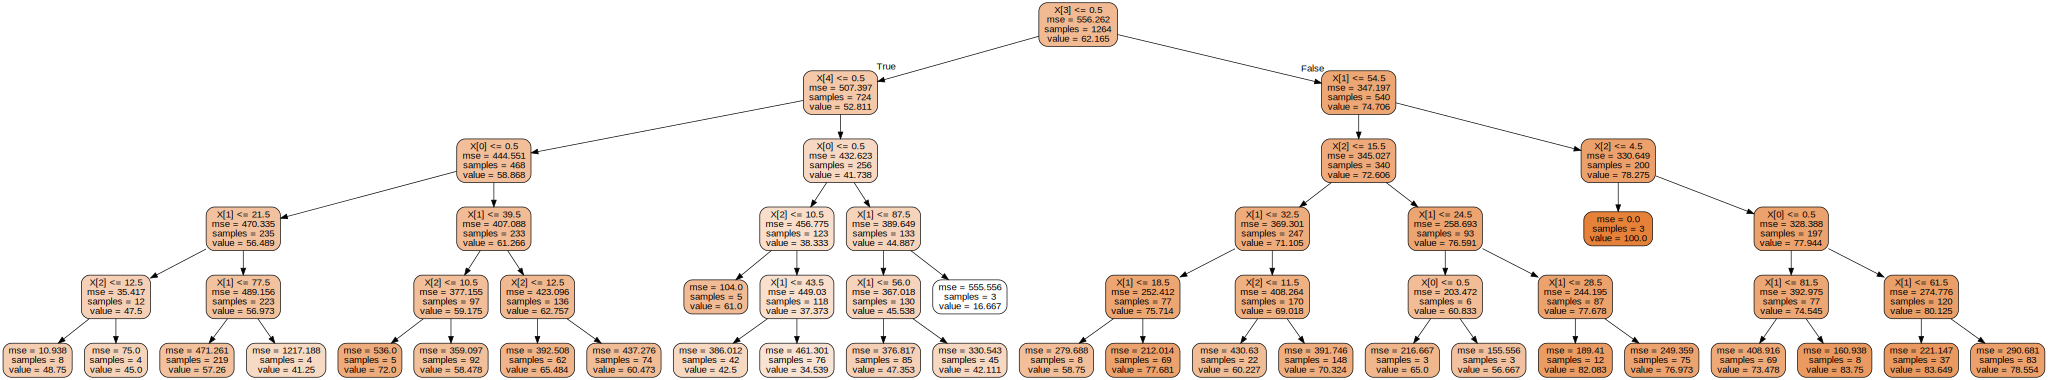

In [5]:
from sklearn.tree import export_graphviz
import graphviz

biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

In [6]:
y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('The test MSE=', MSE1)

The test MSE= 406.672049146


#### (b)

In [7]:
for depth in range(1,20):
    tree = DecisionTreeRegressor(max_depth = depth, min_samples_leaf = 5)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    print('MSE for test set', depth, ' is', MSE)


MSE for test set 1  is 420.022452935
MSE for test set 2  is 400.065398184
MSE for test set 3  is 396.193714632
MSE for test set 4  is 404.596023623
MSE for test set 5  is 411.805927372
MSE for test set 6  is 420.720130352
MSE for test set 7  is 435.769061194
MSE for test set 8  is 465.066971407
MSE for test set 9  is 460.07575137
MSE for test set 10  is 470.424338893
MSE for test set 11  is 472.78981609
MSE for test set 12  is 478.666372324
MSE for test set 13  is 476.839636555
MSE for test set 14  is 480.25506772
MSE for test set 15  is 479.411175931
MSE for test set 16  is 482.9896985
MSE for test set 17  is 482.84236885
MSE for test set 18  is 480.698008344
MSE for test set 19  is 480.698008344


From the table above, we see that the best max_depth value is 3,with a MSE of 396.19. We can see that Pruning the tree significantly lower the MSE.

I plot the tree below:

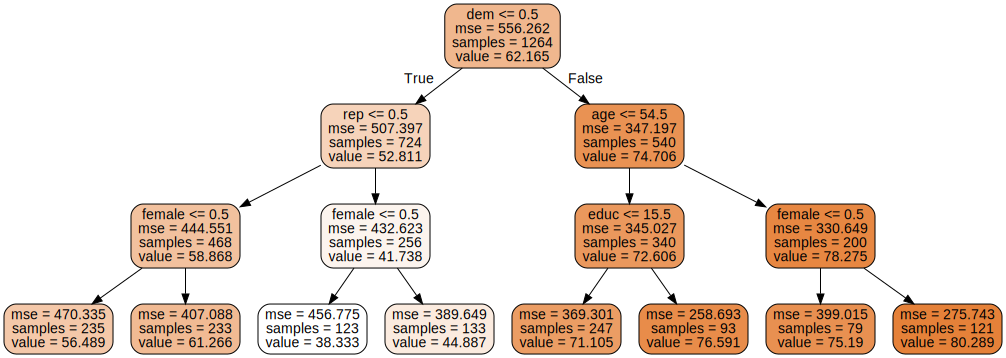

In [8]:
biden_tree = DecisionTreeRegressor(min_samples_leaf = 5, max_depth = 3)
biden_tree.fit(X_train, y_train)
biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    feature_names = ['female', 'age', 'educ', 'dem', 'rep'],
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz2')
graph

#### (c)

In [9]:
from sklearn.ensemble import BaggingRegressor


biden_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state = 20)
biden_tree3.fit(X, y)

y_pred3 = biden_tree3.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('The test MSE=', MSE3)

The test MSE= 402.694268423


In [10]:
# For how to determine the feature importance, I refer to the following sources:
# https://github.com/UC-MACSS/persp-model_W18/issues/228
# http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
# https://github.com/scikit-learn/scikit-learn/issues/8898

tree_feature_importance = np.array([tree.feature_importances_ \
                           for tree in biden_tree3.estimators_])

importances = np.mean(tree_feature_importance, axis = 0)
indices = np.argsort(importances)[::-1]

features = varlist
for f in range(importances.shape[0]):
    print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))

1 .  female :  0.440244032957
2 .  age :  0.19692437878
3 .  educ :  0.195903304666
4 .  dem :  0.104209516709
5 .  rep :  0.062718766888


Based on the restuls above, female is the most important variable, followed by age, education, whether respondent is a Democrat, and whether she's a Republican.

#### (d)

In [11]:
from sklearn.ensemble import RandomForestRegressor

def randomforest_tree(m):
    # Train model and get MSE
    tree = RandomForestRegressor(n_estimators=53, max_features= m, bootstrap=True,
                                  oob_score=True, random_state=15)
    tree.fit(X, y)

    y_pred = tree.oob_prediction_
    MSE = mean_squared_error(y, y_pred)
    
    importances = tree.feature_importances_
    std = np.std([tree.feature_importances_ for tree in tree.estimators_], axis = 0)
    indices = np.argsort(importances)[::-1]

    return MSE, importances

In [12]:
features = ['female', 'age', 'dem', 'rep', 'educ']
for m in range(1, 4):
    MSE, importances = randomforest_tree(m)
    print("When m = ", m, "The MSE = ", MSE)
    print("Feature ranking:")
    for f in range(X.shape[1]):
        print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))
    print("\n")

When m =  1 The MSE =  532.875057972
Feature ranking:
1 .  female :  0.512175098628
2 .  age :  0.150180547154
3 .  dem :  0.192432071629
4 .  rep :  0.123879218183
5 .  educ :  0.0213330644052


When m =  2 The MSE =  538.192542935
Feature ranking:
1 .  female :  0.50758431124
2 .  age :  0.151423695616
3 .  dem :  0.191943514043
4 .  rep :  0.127943907267
5 .  educ :  0.021104571834


When m =  3 The MSE =  535.761962701
Feature ranking:
1 .  female :  0.484652036367
2 .  age :  0.165089462362
3 .  dem :  0.199165322239
4 .  rep :  0.123722379345
5 .  educ :  0.0273707996866


